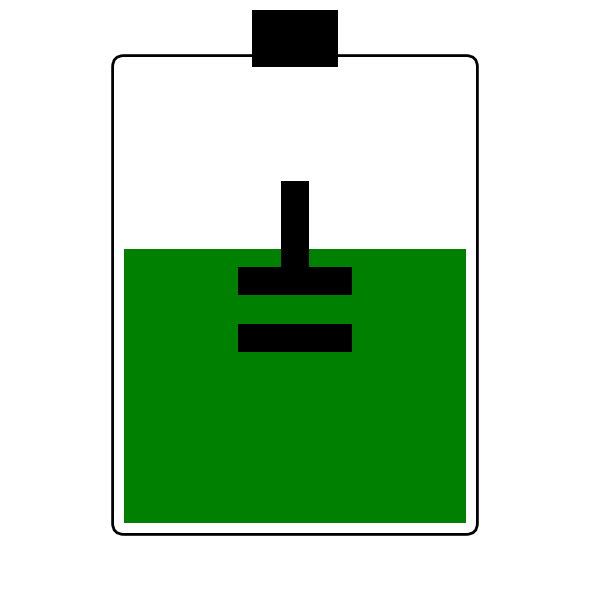

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_battery_soc(soc):
    # Validate input
    if soc < 0 or soc > 1:
        raise ValueError("SOC should be a float between 0 and 1.")

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Define battery properties
    battery_width = 0.6
    battery_height = 0.8
    terminal_width = 0.15
    terminal_height = 0.1

    # Adjust coordinates for centering the battery in the plot
    x_offset = (1 - battery_width) / 2
    y_offset = (1 - battery_height) / 2

    # Draw battery body with rounded corners
    battery_body = patches.FancyBboxPatch((x_offset, y_offset), battery_width, battery_height, boxstyle="round,pad=0.02",
                                          facecolor="white", edgecolor="black", linewidth=2)
    ax.add_patch(battery_body)

    # Draw battery terminal
    terminal_start_x = (1 - terminal_width) / 2
    terminal_start_y = y_offset + battery_height
    battery_terminal = patches.Rectangle((terminal_start_x, terminal_start_y), terminal_width, terminal_height, facecolor="black")
    ax.add_patch(battery_terminal)

    # Draw fill corresponding to SOC
    fill_height = battery_height * soc
    battery_fill_color = "green" if soc > 0.5 else "red"
    battery_fill = patches.Rectangle((x_offset, y_offset), battery_width, fill_height, facecolor=battery_fill_color)
    ax.add_patch(battery_fill)

    # Draw minus sign
    minus_width = 0.2
    minus_height = 0.05
    minus_x = x_offset + (battery_width - minus_width) / 2
    minus_y = 0.5 - minus_height - 0.05
    minus_sign = patches.Rectangle((minus_x, minus_y), minus_width, minus_height, facecolor="black")
    ax.add_patch(minus_sign)

    # Draw plus sign
    plus_width = minus_width
    plus_height = minus_height
    plus_x = minus_x
    plus_y = 0.5
    plus_sign_h = patches.Rectangle((plus_x, plus_y), plus_width, plus_height, facecolor="black")
    plus_sign_v = patches.Rectangle((plus_x + (plus_width - plus_height) / 2, plus_y + (plus_height - minus_height) / 2), 
                                    plus_height, minus_width, facecolor="black")
    ax.add_patch(plus_sign_h)
    ax.add_patch(plus_sign_v)

    # Setting the aspect ratio, limits, and other properties
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')  # Hide axes
    plt.tight_layout()

    # Show the battery
    plt.show()

# Test the function
soc_value = 0.6
display_battery_soc(soc_value)


In [105]:
import pandas as pd


df = pd.read_csv("data/results/mpc_results/1_county/Los_Angeles/cost_results.csv", index_col=0)

df

,horizon,tier1,tier2,peak,total
RandomForest Summer - Horizon: 24 Hours,24.0,9.403022,0.028680,0.415595,9.847297
XGBModel Summer - Horizon: 24 Hours,24.0,9.401358,0.031069,0.415595,9.848022
LinearRegressionModel Summer - Horizon: 24 Hours,24.0,9.405536,0.025871,0.415595,9.847002
Ground Truth,24.0,9.408068,0.021489,0.406893,9.836450


In [106]:
def calculate_net_load_error(df):
    ref_cost = df.loc["Ground Truth", "total"]
    df.drop("Ground Truth", inplace=True, axis=0)
    df["NLE"] = df["total"] - ref_cost
    return df



In [107]:
df_nle = calculate_net_load_error(df)
df_nle.reset_index(names=["model"], inplace=True)
df_nle = df_nle[["model", "NLE", "horizon"]]

In [108]:
df_nle.columns =["model", "NLE", "horizon_in_hours"]

In [29]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


True

In [72]:
from utils.paths import EXPERIMENT_WANDB


In [39]:
api = wandb.Api()
run_id = "1_county_Los_Angeles_60min_aux_data--False"
# Retrieve the run data
run = api.run(f"{EXPERIMENT_WANDB}/{run_id}")

In [60]:

files = []
for file in run.files():
    if "Error metrics" in str(file) in str(file):
        files.append(file)


In [109]:
tab = files[0].download(replace=True)
import json
tab_json = json.load(tab)

In [110]:
df_errors = pd.DataFrame(columns = tab_json["columns"], data = tab_json["data"])

In [111]:
import numpy as np

df_errors["NLE"] = np.nan

In [112]:
df_nle

,model,NLE,horizon_in_hours
0,RandomForest Summer - Horizon: 24 Hours,0.010846,24.0
1,XGBModel Summer - Horizon: 24 Hours,0.011572,24.0
2,LinearRegressionModel Summer - Horizon: 24 Hours,0.010552,24.0


In [114]:
pd.merge(df_errors, df_nle, on=["model", "horizon_in_hours", "NLE"], how="left")

,horizon_in_hours,season,model,rmse,r2_score,mae,smape,mape,max_peak_error,mean_n_peak_error,rmse_skill_score,NLE
0,1,Summer,RandomForest,0.378146,0.812088,0.184932,4.006476,4.271675,0.585180,0.665180,0.368879,NaN
1,1,Summer,XGBModel,0.116150,0.986833,0.070867,1.649801,1.650335,0.609575,0.609575,0.806148,NaN
2,1,Summer,LinearRegressionModel,0.057212,0.996962,0.041993,1.059251,1.062952,0.051968,0.017968,0.904514,NaN
3,4,Summer,RandomForest,0.414141,0.780228,0.229757,5.234781,5.562303,0.585180,0.665180,0.308803,NaN
4,4,Summer,XGBModel,0.224725,0.946203,0.140011,3.292616,3.331187,0.609575,0.609575,0.624936,NaN
5,4,Summer,LinearRegressionModel,0.145229,0.979673,0.098499,2.492805,2.539641,0.080025,0.080025,0.757615,NaN
6,8,Summer,RandomForest,0.438421,0.760728,0.252831,5.762176,6.115598,0.585180,0.665180,0.268281,NaN
7,8,Summer,XGBModel,0.316802,0.879279,0.201048,4.646344,4.801788,0.609575,0.609575,0.471261,NaN
8,8,Summer,LinearRegressionModel,0.228306,0.945760,0.148259,3.585028,3.694257,0.080025,0.080025,0.618959,NaN
9,24,Summer,RandomForest,0.499165,0.639681,0.326411,7.538179,8.088143,0.835913,0.871913,0.166899,NaN
